In [1]:
import pandas as pd
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
import numpy as np

In [2]:
import pandas as pd

# Load PX_last data
PX_last_data = pd.read_csv("../../data/503PXlast.csv")
PX_last_data["DATES"] = pd.to_datetime(PX_last_data["DATES"])

# Reshape PX_last data
PX_last_data_melt = PX_last_data.melt(id_vars=['DATES'], var_name='symbol', value_name="PX_last")

# Load GICS sector data
GICS_data = pd.read_csv("../../data/503_GICSData.csv")
GICS_data.rename(columns={"Symbol": "symbol"}, inplace=True)  # Standardize column names

# Load Market Cap data
MarketCap_data = pd.read_csv("../../data/CUR_MKT_CAP_SPX.csv")
MarketCap_data.rename(columns={'Dates': 'Date'}, inplace=True)  # Standardize column names
MarketCap_data["Date"] = pd.to_datetime(MarketCap_data["Date"])

# Reshape MarketCap data
MarketCap_data_melt = MarketCap_data.melt(id_vars=['Date'], var_name='symbol', value_name="MarketCap")

# Merge datasets
merged_df = pd.merge(GICS_data, PX_last_data_melt, on="symbol", how="left")
merged_df.rename(columns={'DATES': 'Date'}, inplace=True)
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

merged_df = pd.merge(merged_df, MarketCap_data_melt, on=["Date", "symbol"], how="outer")

# Ensure 'gics_sector_name' exists in GICS_data
if "gics_sector_name" not in merged_df.columns:
    raise KeyError("Column 'gics_sector_name' is missing in GICS_data. Check the CSV file structure.")

# Compute yearly data
merged_df["year"] = merged_df["Date"].dt.year

# Compute market cap weights within each sector
merged_df["marketcap_weight"] = merged_df.groupby(["Date", "gics_sector_name"])["MarketCap"].transform(lambda x: x / x.sum())

# Drop rows with missing values
merged_df.dropna(inplace=True)

# Print a preview
print(merged_df.head())

           symbol        gics_sector_name  \
2     A UN Equity             Health Care   
3  AAPL UW Equity  Information Technology   
4  ABBV UN Equity             Health Care   
6   ABT UN Equity             Health Care   
7  ACGL UW Equity              Financials   

                       gics_sub_industry_name  \
2              Life Sciences Tools & Services   
3  Technology Hardware, Storage & Peripherals   
4                               Biotechnology   
6                       Health Care Equipment   
7               Property & Casualty Insurance   

                           gics_industry_name  \
2              Life Sciences Tools & Services   
3  Technology Hardware, Storage & Peripherals   
4                               Biotechnology   
6            Health Care Equipment & Supplies   
7                                   Insurance   

                         gics_industry_group_name  gics_industry  gics_sector  \
2  Pharmaceuticals, Biotechnology & Life Sciences       35

In [3]:
#read in sector ETFs
PX_last_ETF = pd.read_csv("../../data/pxlast_sector_ETF.csv")
CUR_MKT_CAP_ETF = pd.read_csv("../../data/CUR_MKT_CAP_Sector_ETF.csv")
CUR_MKT_CAP_ETF.fillna(0, inplace=True)
PX_last_ETF=pd.melt(PX_last_ETF,id_vars=['Dates'], var_name='symbol',value_name="PX_last")
CUR_MKT_CAP_ETF=pd.melt(CUR_MKT_CAP_ETF,id_vars=['Dates'], var_name='symbol',value_name="CUR_MKT_CAP")
Data_ETF=pd.merge(PX_last_ETF, CUR_MKT_CAP_ETF, on=["Dates", "symbol"], how="outer")
Data_ETF["Dates"] = pd.to_datetime(Data_ETF["Dates"])
Data_ETF.rename(columns={"Dates":"Date"},inplace=True)
Data_ETF.dropna(inplace=True)

In [4]:
Data_ETF["year"] = Data_ETF["Date"].dt.year

In [5]:
# read executive compensation data
compensation_data = pd.read_csv("../data_reformat/merged_data.csv")
compensation_data["Date"] = pd.to_datetime(compensation_data["Date"])
compensation_data["year"] =compensation_data["Date"].dt.year
#merged compensation with sector 
merged_df = pd.merge(merged_df,compensation_data,on=["symbol", "year"],how="left" )

In [9]:
# add columns to data 
merged_df.loc[:,"equity_Compensation_CEO"] = merged_df['TOT_STK_AWD_GIVEN_TO_CEO_EQUIV']+merged_df["TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV"]   # Equity compensation   = Total stock awards + Total option awards
merged_df.loc[:,"cash_incentive_CEO"] = merged_df['TOT_BONUSES_PAID_TO_CEO_EQUIV']+merged_df['TOT_N_EQT_INCENT_GVN_TO_CEO_EQ']         # Cash incentive        = Total bonuses paid + Total equity incentive given
merged_df.loc[:,"Variable_Pay_CEO"] = merged_df["cash_incentive_CEO"]+merged_df["equity_Compensation_CEO"]                             # Variable Pay          = Cash incentive + Equity incentive
merged_df.loc[:,"cash_incentive_CEO_percent"] = merged_df["cash_incentive_CEO"]/merged_df["Variable_Pay_CEO"]                          # Cash incentive ratio  = Cash incentive / (Cash incentive + Equity incentive)


In [8]:
#compute the average sector compensation (change Date_x  to date)
ETF_cash_incentive_CEO_percent = merged_df.groupby(["Date_x", "gics_sector_name"]).apply(lambda g: (g["marketcap_weight"] * g["cash_incentive_CEO_percent"]).sum()).reset_index(name="avg_cash_incentive_CEO_percent")


/tmp/ipykernel_4696/3056152074.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ETF_cash_incentive_CEO_percent = merged_df.groupby(["Date_x", "gics_sector_name"]).apply(lambda g: (g["marketcap_weight"] * g["cash_incentive_CEO_percent"]).sum()).reset_index(name="avg_cash_incentive_CEO_percent")


In [10]:
sector_to_symbol={
  "Communication Services": "XLC US Equity",
  "Consumer Discretionary": "XLY US Equity",
  "Consumer Staples": "XLP US Equity",
  "Energy": "XLE US Equity",
  "Financials": "XLF US Equity",
  "Health Care": "XLV US Equity",
  "Industrials": "XLI US Equity",
  "Materials": "XLB US Equity",
  "Real Estate": "XLRE US Equity",
  "Information Technology": "XLK US Equity",
  "Utilities": "XLU US Equity"
}

ETF_cash_incentive_CEO_percent["symbol"] = ETF_cash_incentive_CEO_percent["gics_sector_name"].map(sector_to_symbol)
ETF_cash_incentive_CEO_percent.rename(columns={"Date_x":"Date"},inplace=True)
Data_ETF = pd.merge(Data_ETF,ETF_cash_incentive_CEO_percent,on=["Date","symbol"],how="inner")

num_bins = 10
Data_ETF['compensation_bins'] = pd.cut(Data_ETF['avg_cash_incentive_CEO_percent'], 
                                      bins=[i/num_bins for i in range(num_bins+1)],
                                      include_lowest=True)

In [11]:
display(Data_ETF)

,Date,symbol,PX_last,CUR_MKT_CAP,year,gics_sector_name,avg_cash_incentive_CEO_percent,compensation_bins
0,2016-01-01,XLB US Equity,43.4200,2104.7410,2016,Materials,0.155396,"(0.1, 0.2]"
1,2016-01-01,XLE US Equity,60.3200,11600.9800,2016,Energy,0.097587,"(-0.001, 0.1]"
2,2016-01-01,XLF US Equity,19.3504,19256.9000,2016,Financials,0.158862,"(0.1, 0.2]"
3,2016-01-01,XLI US Equity,53.0100,5927.8960,2016,Industrials,0.268940,"(0.2, 0.3]"
4,2016-01-01,XLK US Equity,42.8300,13650.1800,2016,Information Technology,0.360587,"(0.3, 0.4]"
...,...,...,...,...,...,...,...,...
5516,2022-09-09,XLP US Equity,73.9800,16373.3874,2022,Consumer Staples,0.183196,"(0.1, 0.2]"
5517,2022-09-09,XLRE US Equity,43.0400,5427.3440,2022,Real Estate,0.144833,"(0.1, 0.2]"
5518,2022-09-09,XLU US Equity,77.3800,18298.3705,2022,Utilities,0.174345,"(0.1, 0.2]"
5519,2022-09-09,XLV US Equity,130.5000,39138.9498,2022,Health Care,0.157227,"(0.1, 0.2]"


In [12]:
result = Data_ETF.groupby(['gics_sector_name', 'compensation_bins'])['PX_last'].mean().reset_index()
result.dropna(inplace=True)
result['compensation_bins_encoded'] = result['compensation_bins'].cat.codes + 1

/tmp/ipykernel_4696/3869203576.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = Data_ETF.groupby(['gics_sector_name', 'compensation_bins'])['PX_last'].mean().reset_index()


In [14]:
display(result)

,gics_sector_name,compensation_bins,PX_last,compensation_bins_encoded
0,Communication Services,"(-0.001, 0.1]",63.575220,1
10,Consumer Discretionary,"(-0.001, 0.1]",161.031538,1
11,Consumer Discretionary,"(0.1, 0.2]",144.405670,2
12,Consumer Discretionary,"(0.2, 0.3]",81.668222,3
20,Consumer Staples,"(-0.001, 0.1]",78.047308,1
21,Consumer Staples,"(0.1, 0.2]",63.773268,2
22,Consumer Staples,"(0.2, 0.3]",51.141027,3
30,Energy,"(-0.001, 0.1]",69.055420,1
31,Energy,"(0.1, 0.2]",68.112723,2
40,Financials,"(-0.001, 0.1]",43.274038,1


In [16]:
display(result)
print(result.info())
print('\nCorrelation')
for sector_name,i in result.groupby("gics_sector_name"):
    y= i["PX_last"]
    x=np.arange(len(y))
    np.corrcoef(x,y)[0, 1]
    print("{} {}".format(sector_name,np.corrcoef(x,y)[0, 1]))

print(result['compensation_bins'].unique())

,gics_sector_name,compensation_bins,PX_last,compensation_bins_encoded
0,Communication Services,"(-0.001, 0.1]",63.575220,1
10,Consumer Discretionary,"(-0.001, 0.1]",161.031538,1
11,Consumer Discretionary,"(0.1, 0.2]",144.405670,2
12,Consumer Discretionary,"(0.2, 0.3]",81.668222,3
20,Consumer Staples,"(-0.001, 0.1]",78.047308,1
21,Consumer Staples,"(0.1, 0.2]",63.773268,2
22,Consumer Staples,"(0.2, 0.3]",51.141027,3
30,Energy,"(-0.001, 0.1]",69.055420,1
31,Energy,"(0.1, 0.2]",68.112723,2
40,Financials,"(-0.001, 0.1]",43.274038,1


<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, 0 to 102
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   gics_sector_name           29 non-null     object  
 1   compensation_bins          29 non-null     category
 2   PX_last                    29 non-null     float64 
 3   compensation_bins_encoded  29 non-null     int8    
dtypes: category(1), float64(1), int8(1), object(1)
memory usage: 1.2+ KB
None

Correlation
Communication Services nan
Consumer Discretionary -0.9480791556728816
Consumer Staples -0.9993800210970138
Energy -1.0
Financials -1.0
Health Care -0.9996367489261041
Industrials -0.9959799094215706
Information Technology -0.9429552460282251
Materials -1.0
Real Estate -0.9955129073414128
Utilities -0.9711146668338135
[(-0.001, 0.1], (0.1, 0.2], (0.2, 0.3], (0.3, 0.4], (0.4, 0.5]]
Categories (10, interval[float64, right]): [(-0.001, 0.1] < (0.1, 0.2] < (0.2, 0.3] <

/home/lucas/.local/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/lucas/.local/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/lucas/.local/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [21]:
compensation_bin_mapping = {
    1: "(0.0, 0.1]",
    2: "(0.1, 0.2]",
    3: "(0.2, 0.3]",
    4: "(0.3, 0.4]",
    5: "(0.4, 0.5]",
    6: "(0.5, 0.6]",
    7: "(0.6, 0.7]",
    8: "(0.7, 0.8]",
    9: "(0.8, 0.9]",
    10: "(0.9, 1.0]",
}

def plot(data, sector):
    sector_data = data[data['gics_sector_name'] == sector]

    # Ensure all compensation_bins_encoded (1-10) are represented
    all_bins = range(1, 11)

    # Group by encoded compensation bin and compute average price
    grouped_data = sector_data.groupby('compensation_bins_encoded')['PX_last'].mean()

    # Reindex to include all bins, filling missing ones with NaN
    grouped_data = grouped_data.reindex(all_bins)

    # Plot the bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(grouped_data.index, grouped_data.values, color='royalblue', alpha=0.7, label='Average Price')

    # Perform linear regression
    x = np.array(grouped_data.index)
    y = grouped_data.values
    mask = ~np.isnan(y)  # Remove NaN values before regression
    x_valid = x[mask]
    y_valid = y[mask]

    if len(x_valid) > 1:  # Ensure enough data for regression
        slope, intercept = np.polyfit(x_valid, y_valid, 1)
        trendline = np.poly1d((slope, intercept))
        plt.plot(x, trendline(x), color='red', linestyle='--', linewidth=2, label='Trend Line')

    plt.xlabel('Compensation Bins Encoded')
    plt.ylabel('Average Price')
    plt.title(f'Average Price per Compensation Bin in {sector}')

    plt.ylim(bottom=0)
    
    # Corrected xticks
    plt.xticks(ticks=list(compensation_bin_mapping.keys()), labels=list(compensation_bin_mapping.values()), rotation=45, ha='right')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

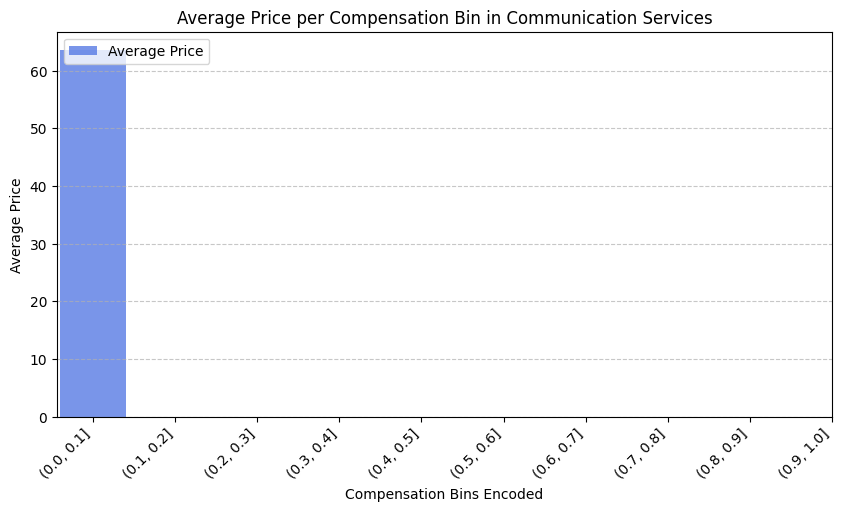

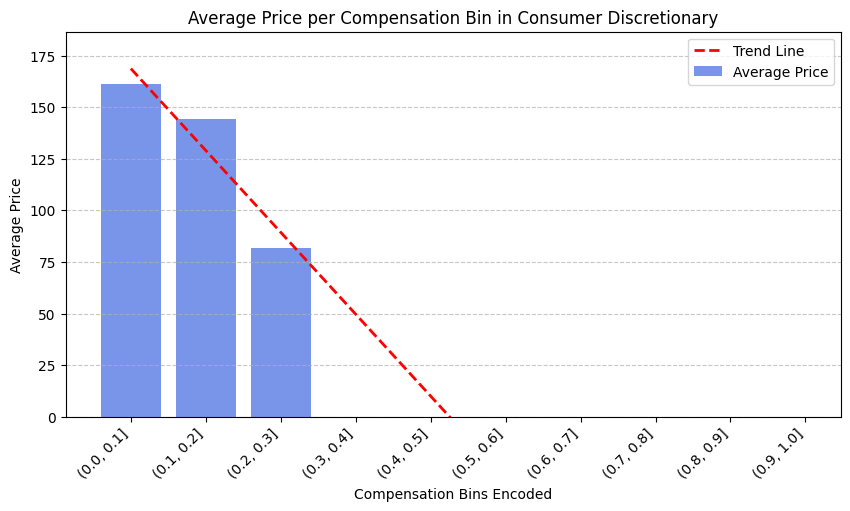

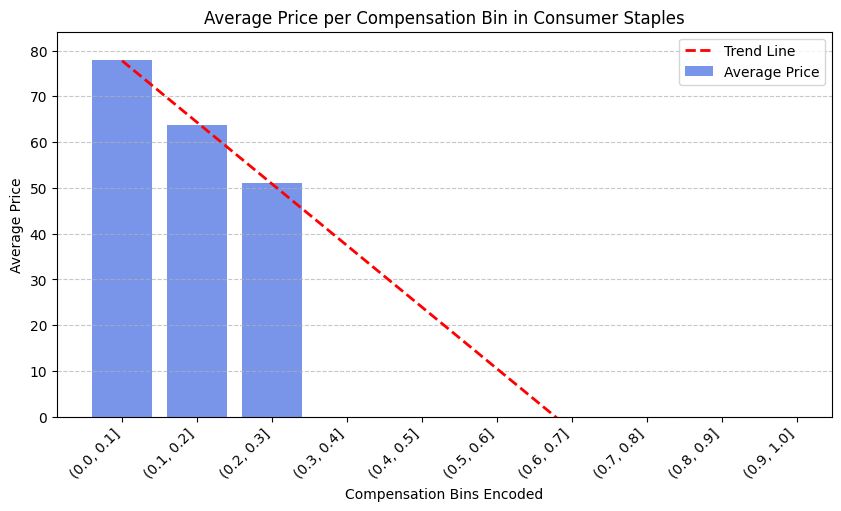

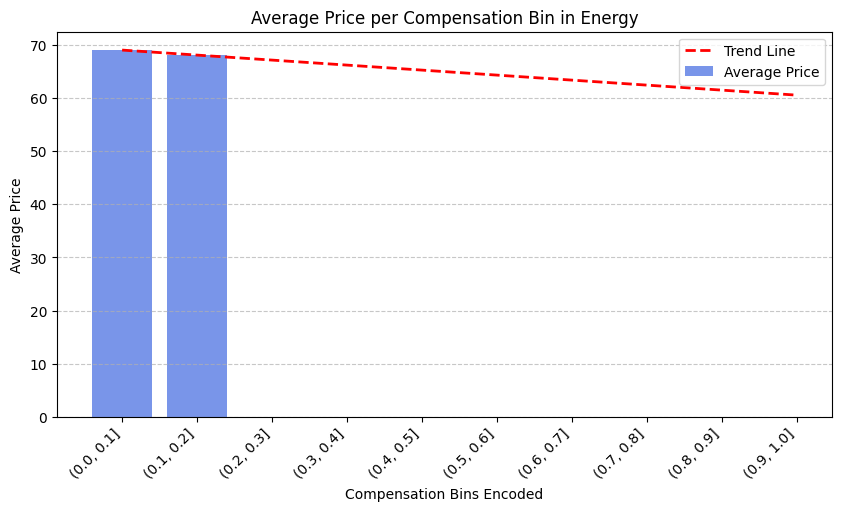

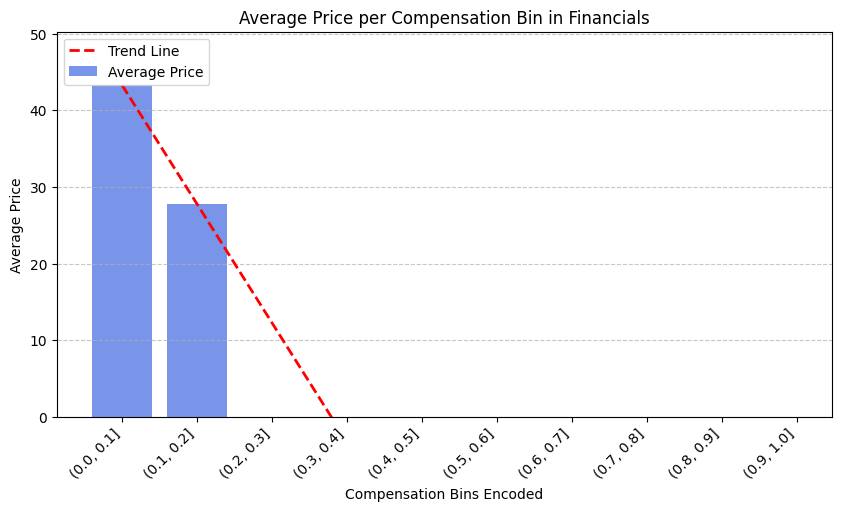

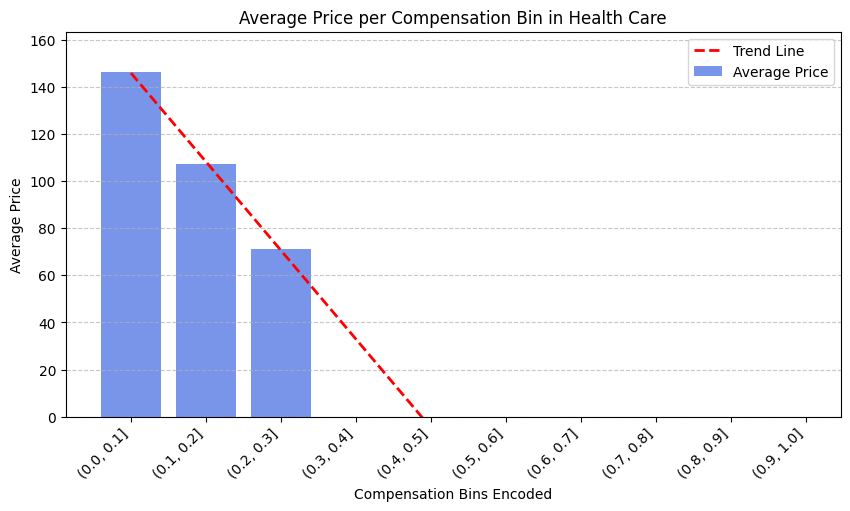

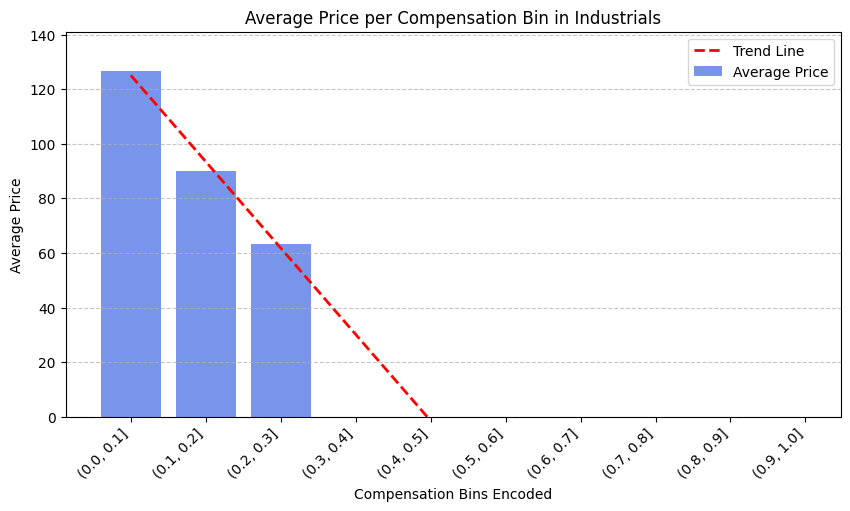

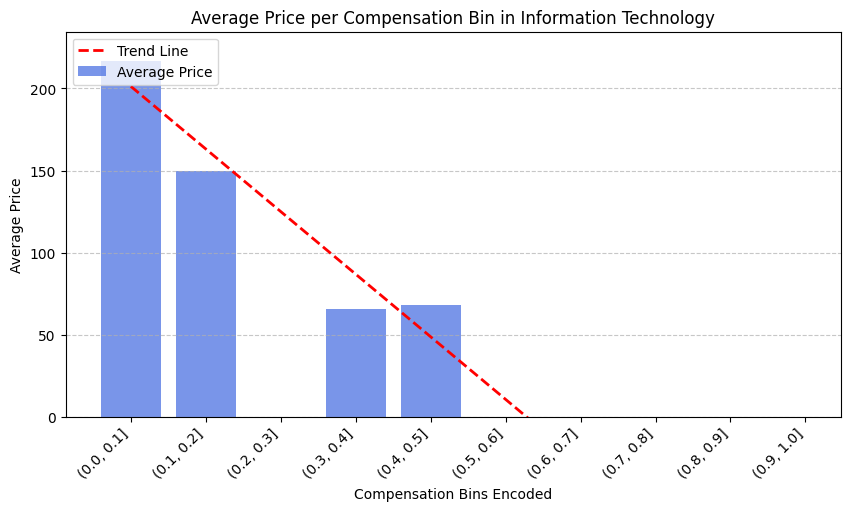

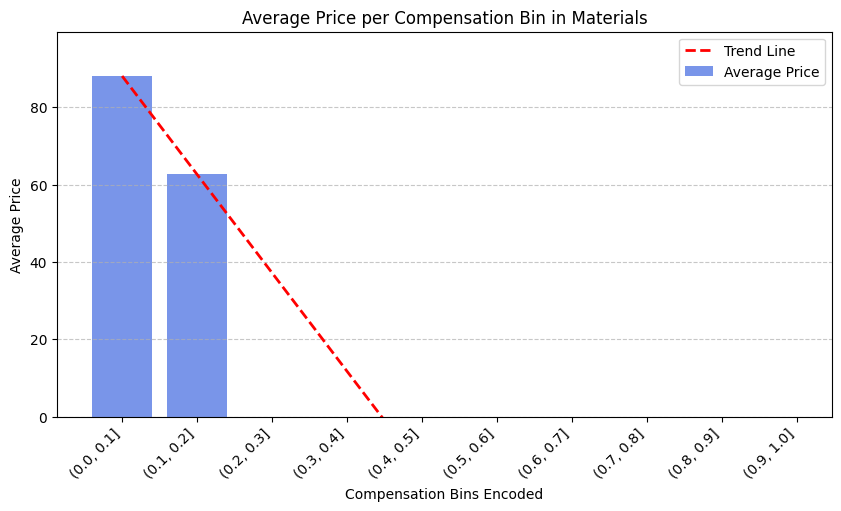

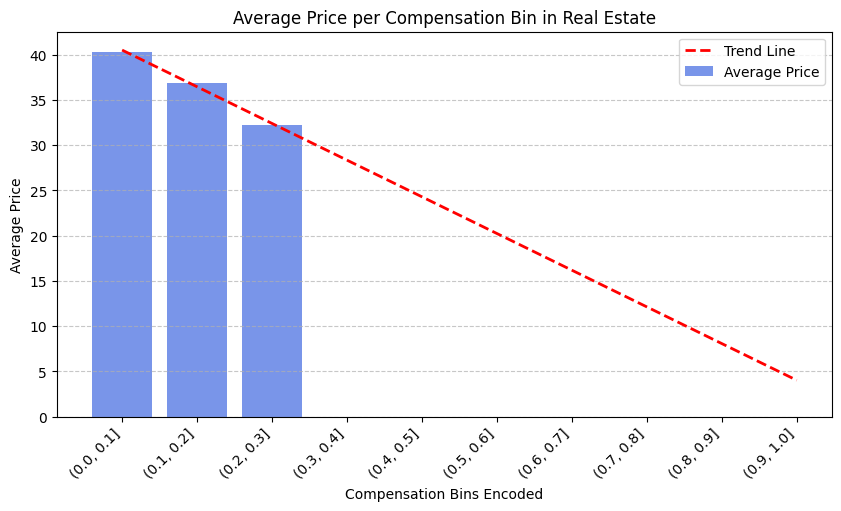

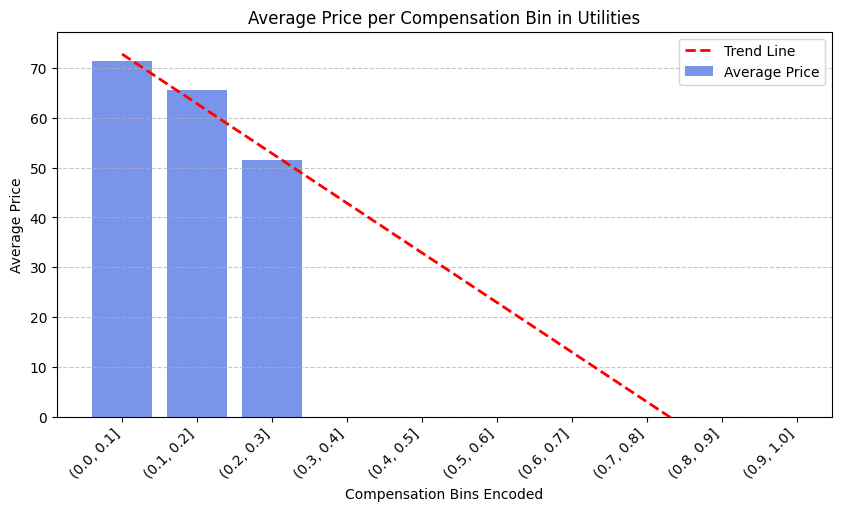

In [22]:
for i in result['gics_sector_name'].unique():
    plot(result, i)